In [74]:
import pandas as pd
import geopandas as gpd
import json 
from shapely.geometry import shape, Point
import shapely

import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import folium

from vincenty import vincenty

import requests
import urllib.parse
import re

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

from sklearn.linear_model import ElasticNet

import keras
from keras.models import Sequential
from keras.layers import Dense

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance


# Option d'affchage
pd.set_option('display.max_columns', None)

In [75]:
# Importation de la base des données calculées

df0 = pd.read_csv('data/données_calculees.csv', index_col = 0)

# Copie de la base

df = df0.copy()

# I. Préparation des données

In [76]:
# Standardisation des données

min_max_scaler = preprocessing.MinMaxScaler()
df[[
    'Numero', 'NbPieces', 'lon', 'lat', 
    'periode_construction', 'Arrondissement', 'Quartier',
    'prixm2', 'score_commerce', 'score_commerce_lux','score_monument', 
    'score_jardin', 'score_metro'
    ]] = min_max_scaler.fit_transform(df[[
                        'Numero', 'NbPieces', 'lon', 'lat', 
                        'periode_construction', 'Arrondissement', 'Quartier',
                        'prixm2', 'score_commerce', 'score_commerce_lux','score_monument', 
                        'score_jardin', 'score_metro'
                                        ]])

In [77]:
# Encodage de la variable 'TypeVoie'

df['TypeVoie'] = df['TypeVoie'].astype(str)
le = LabelEncoder()
 
df['TypeVoie_encoded'] = le.fit_transform(df.TypeVoie)

ohe = OneHotEncoder()
 
X = ohe.fit_transform(df.TypeVoie_encoded.values.reshape(-1,1)).toarray()
 
dfOneHot = pd.DataFrame(X, columns = ["TypeVoie_"+str(int(i)) for i in range(X.shape[1])])
df = pd.concat([df, dfOneHot], axis=1).drop(columns = ['TypeVoie', 'TypeVoie_encoded']).dropna()


Les différentes modalités sont :  
0 : Allée, 1 : Avenue, 2 : Boulevard,  3 : CAR,  4 : Cité,  5 : Cour, 6 : CRS,  7 : Impasse,  8 : Passage,  9 : Place,  10 : Quai, 11 : Rue, 12 : Square, 13 : VC, 14 : Villa, 15 : nan

In [78]:
# On définit les vecteurs

y = df[['prixm2']]
X = df.drop(columns = ['prixm2'])

# On choisit un échantillon de validation de 20 %

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

# II. Modélisation

On choisira la métrique MSE (mean squared error) car nous avons affaire à une variable continue.

## II.1 Regressions linéaires et polynomiales

### Regression linéaire multiple

On commence par une regression linéaire pour avoir une première idée de l'influence des variables sur le prix

In [99]:
lin_reg = LinearRegression().fit(X_train, y_train)

# On prédit à partir de l'échantillon de test pour calculer les scores

y_pred = lin_reg.predict(X_test)

In [100]:
px.histogram(pd.DataFrame([
    (X.columns[i], lin_reg.coef_[0][i]) for i in range(28)
                    ]).T.rename(index = {0 : 'variable', 1 : 'coeff'}).T, x = 'variable', y = 'coeff'
            ).show()

print('MSE :', mean_squared_error(y_test, y_pred))

MSE : 0.016166896155388445


In [101]:
# Affichage des p-values

mod = sm.OLS(y,X)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
pd.DataFrame(p_values).T

,Numero,NbPieces,lon,lat,score_commerce,score_commerce_lux,periode_construction,Arrondissement,Quartier,score_jardin,score_monument,score_metro,TypeVoie_0,TypeVoie_1,TypeVoie_2,TypeVoie_3,TypeVoie_4,TypeVoie_5,TypeVoie_6,TypeVoie_7,TypeVoie_8,TypeVoie_9,TypeVoie_10,TypeVoie_11,TypeVoie_12,TypeVoie_13,TypeVoie_14,TypeVoie_15
P>|t|,0.000004,0.145941,0.000718,0.000019,8.428105e-25,3.540958e-26,0.036721,0.125349,0.012068,0.332379,6.746218e-115,6.591719e-08,8.649142e-43,0.0,8.259000e-274,0.049411,3.701278e-79,0.00005,1.081685e-19,1.362097e-66,1.631331e-104,1.311025e-117,3.075773e-129,0.0,1.840972e-112,1.510924e-07,1.527402e-117,0.000011


On observe que :  

- les variables avec les plus petites p-values sont les score aux commerces et score_monument
- être proche des commerces atypiques mais loin des commerces en général ferait monter le prix
- la variable qui semble être la plus significative est score_monument (p-value la plus basse sans compter les TypeVoie, et coefficient le plus grand)
- score_metro a ettonement un coefficient négatif
- Les p-values concernant TypeVoie ne semblent pas pertinentes, on manque sans doute de données pour certaines modalités

### Regressions polynomiales

Il est très probable que les variables n'aient pas un effet linéaire sur le prix au m<sup>2<sup>.
    
C'est pourquoi on choisit de faire des regressions polynomiales, en augmentant progressivement le degré, et en s'arrêtant dès qu'on observe de l'overfitting sur l'échantillon de test.

In [107]:
def poly_reg(n):
    """
    Cette fonction effectue une regression polynomiale sur la base d'entrainement et affiche 
    la MSE pour l'echantillon de test
    """
    
    # Agrandissement de la base d'entrainement avec l'ajout des degrés successifs
    poly_X = X_train.copy()
    
    for i in range(2, n+1):
        
        index = [str(j) + '^' + str(i) for j in X.columns[:12]]
        poly_X[[str(j) + '^' + str(i) for j in X.columns[:12]]] = poly_X[[j for j in X.columns[:12]]].pow(i)
    
    poly_reg = LinearRegression().fit(poly_X, y_train)
    
    # Agrandissement de la base d'de test avec l'ajout des degrés successifs
    poly_X_test = X_test.copy()
    
    for i in range(2, n+1):
        
        index = [str(j) + '^' + str(i) for j in X.columns[:12]]
        poly_X_test[[str(j) + '^' + str(i) for j in X.columns[:12]]] = poly_X_test[[j for j in X.columns[:12]]].pow(i)
    
    # Regression
    y_pred = poly_reg.predict(poly_X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Affichage des coefficients pour le degré 2
    fig = px.histogram(pd.DataFrame([
        (poly_X.columns[i], poly_reg.coef_[0][i]) for i in range(28 + 12 * (n - 1))
                            ]).T.rename(
        index = {0 : 'variable', 1 : 'coeff'}
                                        ).T.sort_values(by = 'variable'), x = 'variable', y = 'coeff') 
    
    if n == 2:
        
        fig.show()
        
    else:
        
        print('degré : ', n)

    return MSE

In [108]:
# Regressions jusqu'au degré 22

list_mse_degree = [polyreg(i) for i in range(2, 23)]

px.line(x = [i for i in range(2, 23)], y = list_mse_degree).show()

degree :  3
degree :  4
degree :  5
degree :  6
degree :  7
degree :  8
degree :  9
degree :  10
degree :  11
degree :  12
degree :  13
degree :  14
degree :  15
degree :  16
degree :  17
degree :  18
degree :  19
degree :  20
degree :  21
degree :  22


On observe que :  
- le degré à partir duquel on observe de l'overfitting dépend beaucoup de l'échantillon de test, qui est choisi au hasard. On a pu observer de l'overfitting au degré 25 comme au degré 8 avec des échantillons différents
- Dans la regression de degré 2, pour presque chaque variable, le coefficient de la variable et de la variable au carré ont un exposant de signe opposé. Cela semble signifier que le premier coeffient "compense" l'effet du deuxième, et donc que l'effet de chaque variable est plus complexe qu'un effet linéaire
- Seul score_monument a significativement deux coefficients positif. Son effet semble clair : plus on est proche des monuments, plus le prix est haut

## II.2 Regression pénalisée

Etant donnée le grand nombre de variables dont nous disposons, il nous parrait cohérent d'utiliser une regression pénalisée afin de sélectionner les variables les plus significatives.
De plus, certaines de nos variables sont corrélées entre elles.

Ici, on a fait baisser l1_ratio progressivement jusqu'à obtenir 10 variables dont les coefficients sont non nul.

In [117]:
EN_reg = ElasticNet(alpha=.1, copy_X=True, fit_intercept = False, l1_ratio=.05)

EN_reg.fit(X_train, y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=False, l1_ratio=0.05,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [118]:
pd.DataFrame([(X.columns[i], EN_reg.coef_[i]) for i in range(28)]).T.rename(index = {0 : 'variable', 1 : 'coeff'})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
variable,Numero,NbPieces,lon,lat,score_commerce,score_commerce_lux,periode_construction,Arrondissement,Quartier,score_jardin,score_monument,score_metro,TypeVoie_0,TypeVoie_1,TypeVoie_2,TypeVoie_3,TypeVoie_4,TypeVoie_5,TypeVoie_6,TypeVoie_7,TypeVoie_8,TypeVoie_9,TypeVoie_10,TypeVoie_11,TypeVoie_12,TypeVoie_13,TypeVoie_14,TypeVoie_15
coeff,0,0,0.0467608,0.0345475,0,0.00612175,0.0252166,0.0356367,0.0375021,0,0.114026,0,0,0.0185942,0.00219404,0,0,0,0,0,0,0,0,0.0683251,0,0,0,0


In [119]:
# On retient alors les variables suivantes

signif = ['lon', 'lat', 'score_commerce_lux', 'periode_construction', 'Arrondissement', 'Quartier', 
   'score_monument', 'TypeVoie_1', 'TypeVoie_2', 'TypeVoie_11', ]

## II.3 Réseau de neurones

Les réseaux de neurones sont des architectures qui permettent de rendre compte des influences complexes des variables sur le prix.

Après plusieurs essais, un réseau 28 - 2 - 3 - 1 fournit des résultats satisfaisant. 

In [153]:
model = Sequential()

model.add(Dense(2, input_dim = 28, activation = 'relu'))
model.add(Dense(3))
model.add(Dense(1))

In [154]:
model.compile(optimizer = 'adam', loss = 'mse', metrics=['mse'])

In [155]:
history = model.fit(X, y, validation_split = 0.2,  epochs = 30)

Train on 19972 samples, validate on 4993 samples
Epoch 1/30
19972/19972 [==============================] - 1s 61us/step - loss: 0.0257 - mse: 0.0257 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 2/30
19972/19972 [==============================] - 1s 52us/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 3/30
19972/19972 [==============================] - 1s 59us/step - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 4/30
19972/19972 [==============================] - 1s 56us/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 5/30
19972/19972 [==============================] - 1s 60us/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 6/30
19972/19972 [==============================] - 1s 62us/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 7/30
19972/19972 [==============================] - 1s 50us/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0125 - val_mse:

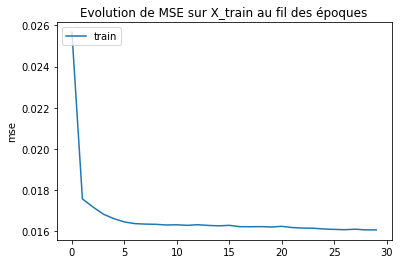

In [156]:
plt.plot(history.history['mse'])
plt.title('Evolution de MSE sur X_train au fil des époques')
plt.ylabel('mse')
plt.legend(['train'], loc='upper left')
plt.show()

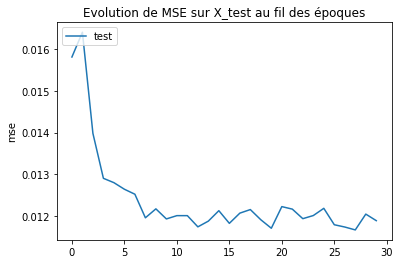

In [157]:
plt.plot(history.history['val_mse'])
plt.title('Evolution de MSE sur X_test au fil des époques')
plt.ylabel('mse')
plt.legend(['test'], loc='upper left')
plt.show()

 **En prenant en compte les variables sélectionnées par ElsaticNet précédemment**

In [158]:
X_significatif = X[signif]

In [159]:
# On reprend la même architecture en changeant le nombre de neurones d'entrée.

model_significatif = Sequential()

model_significatif.add(Dense(2, input_dim = 10, activation='relu'))
model_significatif.add(Dense(3))
model_significatif.add(Dense(1))

In [160]:
model_significatif.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])

In [161]:
history_significatif = model_significatif.fit(X_significatif, y, validation_split = 0.2,  epochs = 30)

Train on 19972 samples, validate on 4993 samples
Epoch 1/30
19972/19972 [==============================] - 1s 65us/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0159 - val_mse: 0.0159
Epoch 2/30
19972/19972 [==============================] - 1s 53us/step - loss: 0.0181 - mse: 0.0181 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 3/30
19972/19972 [==============================] - 1s 59us/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0156 - val_mse: 0.0156
Epoch 4/30
19972/19972 [==============================] - 1s 53us/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 5/30
19972/19972 [==============================] - 1s 59us/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0160 - val_mse: 0.0160
Epoch 6/30
19972/19972 [==============================] - 1s 48us/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 7/30
19972/19972 [==============================] - 1s 50us/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0152 - val_mse:

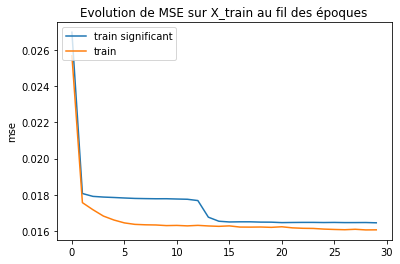

In [162]:
plt.plot(np.array(history_significatif.history['mse']))
plt.title('Evolution de MSE sur X_train au fil des époques')
plt.plot(history.history['mse'])
plt.ylabel('mse')
plt.legend(['train significant', 'train'], loc='upper left')
plt.show()

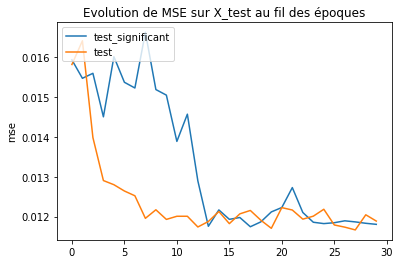

In [163]:
plt.plot(history_significatif.history['val_mse'])
plt.plot(history.history['val_mse'])
plt.title('Evolution de MSE sur X_test au fil des époques')
plt.ylabel('mse')
plt.legend(['test_significant', 'test'], loc='upper left')
plt.show()

Observations :  
- le comportement de la loss dépend de la sélection de l'échantillon de test. On a pu avoir des modèles qui apprenaient bien (décroissance de la loss dans les 4 graphiques précedents), comme des modèles qui apprenaient mal.
- La plupart du temps, on observe quand même un apprentissage qui fonctionne. Mais les performance des deux réseaux sont après 15 époqoques similaires (l'apprentissage avec plus de variable est même plus efficace avec peu d'époques)

**Importance des paramètres (méthode des permutations)**

In [165]:
perm = PermutationImportance(model_significatif, scoring = 'r2', random_state = 1).fit(X_significatif,y)
eli5.show_weights(perm, feature_names = X_significatif.columns.tolist())

Weight,Feature
0.0836 ± 0.0040,Arrondissement
0.0683 ± 0.0038,score_monument
0.0063 ± 0.0018,Quartier
0.0062 ± 0.0009,lon
0.0042 ± 0.0011,TypeVoie_1
0.0009 ± 0.0004,lat
0.0004 ± 0.0003,periode_construction
0.0004 ± 0.0001,score_commerce_lux
0.0002 ± 0.0002,TypeVoie_2
-0.0000 ± 0.0001,TypeVoie_11


On constate ici en général l'importance du score_monument et de l'arrondissement, largement les plus important selon ce modèle (poids 10 fois supérieur aux autres variables).

In [ ]:
- comparer les mse
- matrice de corr au début
- ajout du clustering